# RegionalCooling

In [40]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import copy
from scipy import ndimage
import glob
%matplotlib inline

In [41]:
import sys
sys.path.append("./opmap/opmap")

In [42]:
from RawCam import RawCam
from VmemMap import VmemMap
from PhaseMap import PhaseMap
from PhaseVarianceMap import PhaseVarianceMap
from APDMap import APDMap

In [83]:
df = pandas.DataFrame([
    ['2005-04-16-1', 'C001S0025@'],
    ['2005-08-24-2', 'C001S0011@'],
    ['2006-02-18-1', 'C001S0011@'],
    ['2006-02-17', 'C001S0007'],
    ['2006-02-17', 'C001S0015'],
    ['2006-02-17', 'C001S0018'],
    ['2006-02-17', 'C001S0024'],
    ], columns=['sample', 'session'])
df.to_csv('list.csv')
df

,sample,session
0,2005-04-16-1,C001S0025@
1,2005-08-24-2,C001S0011@
2,2006-02-18-1,C001S0011@
3,2006-02-17,C001S0007
4,2006-02-17,C001S0015
5,2006-02-17,C001S0018
6,2006-02-17,C001S0024


In [98]:
dir_src = '/mnt/recordings/ExperimentData/'
dir_dst = '/mnt/recordings/AnalysisResult/Tomii/2017-11-27/'

In [84]:
s = df.loc[6,:]
sample = s["sample"]
session = s["session"]
target = "{0}/{1}/{2}".format(dir_src, sample, session)
print(target)

/mnt/recordings/ExperimentData/2006-02-17/C001S0024


In [87]:
cam = RawCam(
    path=target,
     cam_type='sa4',
     image_width=256, image_height=256,
     frame_start=0, frame_end=-1)
cam.setIntROI(val_min=100)

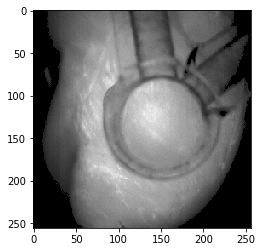

In [88]:
cam.showFrame(900)

In [89]:
vmem = VmemMap(cam)
vmem.smooth(size=15)
pmap = PhaseMap(vmem, shrink=2)
pvmap = PhaseVarianceMap(pmap, size=3)

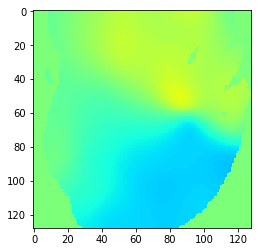

In [90]:
pmap.showFrame(900)

In [105]:
path = target.replace(dir_src, dir_dst)
print path

/mnt/recordings/AnalysisResult/Tomii/2017-11-27/2006-02-17/C001S0024


In [106]:
vmem.saveImage(os.path.join(path, 'vmem'))
pmap.saveImage(os.path.join(path, 'pmap'))
#pvmap.saveImage(os.path.join(path, 'pvmap'))

In [99]:
threshold = 0.4

APV_array = np.zeros((128, 128))
phase_variance_array = copy.deepcopy(pvmap.data)
ROI = copy.deepcopy(pvmap.roi)
core = (phase_variance_array > threshold) * 1
core_count = np.sum(core, axis=0)

for i in range(128):
    for j in range(128):
        if ROI[i,j] != 0:
            data = copy.deepcopy(phase_variance_array[:, i, j])
            time = data.shape[0]
            while np.max(data) > threshold:
                x_pos = np.argmax(data)
                x_max = x_pos + 1
                x_min = x_pos - 1
                while x_max < time and data[x_max - 1] > data[x_max]:
                    x_max += 1
                while x_min > -1 and data[x_min] < data[x_min + 1]:
                    x_min -= 1
                data[x_min+2:x_max] = 0
            APV_array[i,j] = np.sum(data)/len(np.nonzero(data)[0])

IOError: [Errno 2] No such file or directory: '/mnt/recordings/AnalysisResult/2017-11-27/2006-02-17/C001S0024/APV_cam.png'

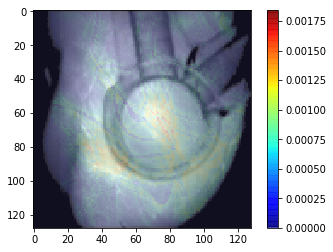

In [101]:
import cv2

raw = cv2.resize(cam.data[0], (128, 128))
raw = raw/np.max(raw)
plt.imshow(APV_array, cmap='jet', alpha=0.7)
plt.colorbar()
plt.imshow(raw, cmap='gray', alpha=0.8)
plt.savefig(os.path.join(path, 'APV_cam.png'), dpi=300, transparent=True)
plt.close()

## APD計算

In [45]:
APD = APDMap(vmem)

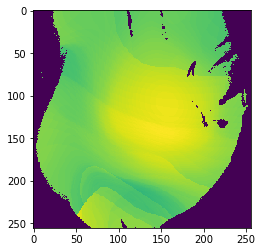

In [47]:
plt.imshow(APD.data[1000])